In [3]:
!pip install easyocr


Defaulting to user installation because normal site-packages is not writeable
  Using cached easyocr-1.7.2-py3-none-any.whl.metadata (10 kB)
  Using cached torchvision-0.23.0-cp39-cp39-win_amd64.whl.metadata (6.1 kB)
  Using cached opencv_python_headless-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached easyocr-1.7.2-py3-none-any.whl (2.9 MB)
Using cached torchvision-0.23.0-cp39-cp39-win_amd64.whl (1.6 MB)
Using cached opencv_python_headless-4.12.0.88-cp37-abi3-win_amd64.whl (38.9 MB)

   ---------------------------------------- 0/3 [opencv-python-headless]



ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Lenovo\\AppData\\Roaming\\Python\\Python39\\site-packages\\cv2\\cv2.pyd'
Check the permissions.



In [1]:
import numpy
import spacy
import easyocr

print("✅ All libraries are ready!")
print("NumPy version:", numpy.__version__)


✅ All libraries are ready!
NumPy version: 1.26.4


In [2]:
import easyocr
print("✅ EasyOCR installed successfully!")


✅ EasyOCR installed successfully!


In [20]:
# Cell 1 - imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pytesseract
import easyocr    # optional, install if not present
from rapidfuzz import process, fuzz
import re
import os

# If Tesseract is not in PATH, set this (adjust to your install)
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

img_path = r"D:\ehr\prescription\29.jpg"   # update if needed


In [21]:
# Cell 2 - helper functions
def show_image_bgr(img, title=None, figsize=(6,8)):
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=figsize); plt.imshow(rgb); plt.axis('off'); 
    if title: plt.title(title); plt.show()
    
def run_tesseract_on_image(img, lang='eng', psm=6, oem=3, config_extra=""):
    """
    psm: Page segmentation mode (3 = fully automatic; 6 = single block of text; 11/12 for sparse)
    oem: OCR Engine Mode (3 = default LSTM+legacy)
    config_extra: extra tesseract config string (like '-c tessedit_char_whitelist=...')
    """
    config = f"--oem {oem} --psm {psm} {config_extra}"
    text = pytesseract.image_to_string(img, lang=lang, config=config)
    return text


In [22]:
# Cell 3 - preprocessing variants
def preprocess_resize(img, scale=2.0):
    h,w = img.shape[:2]
    return cv2.resize(img, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_CUBIC)

def preprocess_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def preprocess_bilateral(img_gray, d=9, sigmaColor=75, sigmaSpace=75):
    return cv2.bilateralFilter(img_gray, d, sigmaColor, sigmaSpace)

def preprocess_gaussian(img_gray, k=5):
    return cv2.GaussianBlur(img_gray, (k,k), 0)

def preprocess_adaptive_thresh(img_gray, blockSize=15, C=8):
    return cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY, blockSize, C)

def preprocess_otsu(img_gray):
    _, th = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return th

def deskew(img_gray):
    coords = np.column_stack(np.where(img_gray < 255))
    if coords.shape[0] == 0:
        return img_gray
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h,w) = img_gray.shape[:2]
    M = cv2.getRotationMatrix2D((w/2,h/2), angle, 1.0)
    return cv2.warpAffine(img_gray, M, (w,h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)


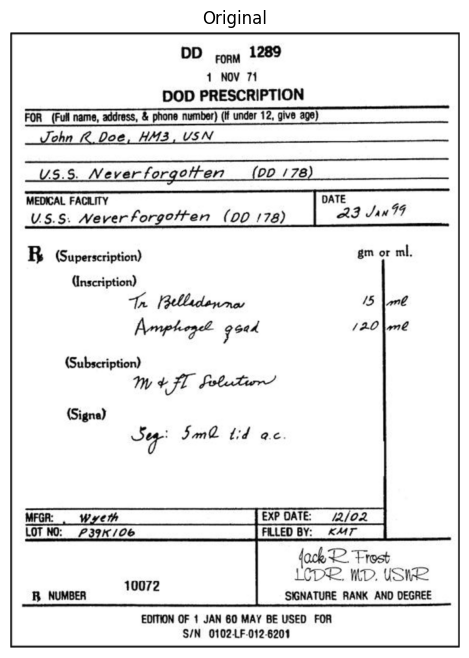

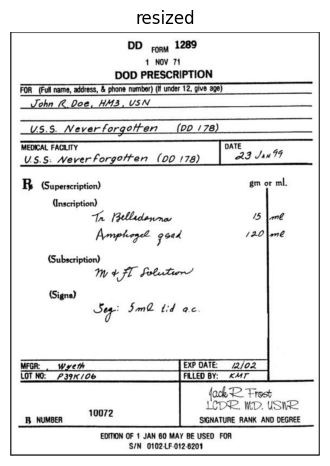

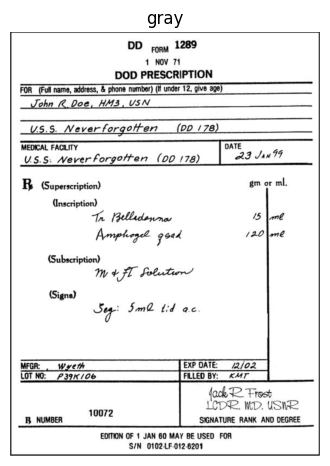

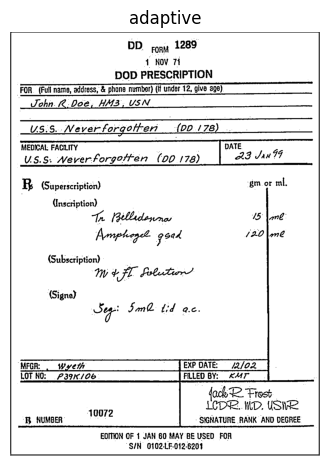

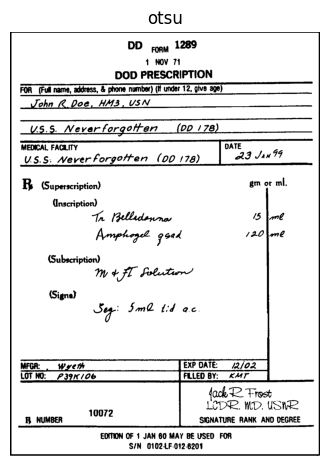

In [23]:
# Cell 4 - load and build variants
orig = cv2.imread(img_path)
if orig is None:
    raise FileNotFoundError(f"Image not found at {img_path}. Use correct path.")

show_image_bgr(orig, "Original")

# Build variants and store (name -> image)
variants = {}
variants['orig'] = orig.copy()
# resized then gray
res = preprocess_resize(orig, scale=1.8)
variants['resized'] = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)  # for display only
gray = preprocess_gray(res)
variants['gray'] = gray
variants['deskew'] = deskew(gray)
variants['bilateral'] = preprocess_bilateral(gray)
variants['gauss'] = preprocess_gaussian(gray)
variants['adaptive'] = preprocess_adaptive_thresh(gray)
variants['otsu'] = preprocess_otsu(gray)

# Display a few key variants
for k in ['resized','gray','adaptive','otsu']:
    imgv = variants[k]
    if imgv.ndim==2:
        plt.figure(figsize=(4,6)); plt.imshow(imgv, cmap='gray'); plt.title(k); plt.axis('off')
    else:
        plt.figure(figsize=(4,6)); plt.imshow(imgv); plt.title(k); plt.axis('off')
plt.show()


In [24]:
# Cell 5 - tesseract runs with different PSM values
psm_values = [6, 11, 3]   # 6 = assume a single block, 11 = sparse text, 3 = automatic
results = {}

# use either color or grayscale/threshold images; pytesseract accepts PIL, CV2 images
for name,img in variants.items():
    # convert to proper format for tesseract: if RGB convert to BGR, if gray OK
    if isinstance(img, np.ndarray) and img.ndim==3:
        img_for_ocr = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # tesseract accepts RGB as well
    else:
        img_for_ocr = img.copy()
    for psm in psm_values:
        key = f"{name}_psm{psm}"
        try:
            text = run_tesseract_on_image(img_for_ocr, psm=psm, oem=3)
        except Exception as e:
            text = f"ERROR: {e}"
        results[key] = text

# Print concise outputs
for k,txt in results.items():
    print("-----", k, "-----")
    print(txt[:400].strip().replace('\n\n','\n'))
    print()


----- orig_psm6 -----
DD fonm 1289
1 NOV 71
DOD PRESCRIPTION
FOR (Full name, address, & phone number) (If under 12, give age)
EE 1, a ees
A a ccc
US.S. Neverforgotten (bD 178)
MEDICAL FACILITY DATE
V.S.S. Neverforgotten (00 178) 23 Nan 9
B. Guperscription) gm or ml.
(nscription)
Ta (pelladeywra 15 Nn
Aenphegel goed /20\me
(Subscription)
Wt fl Probation”
(Signe)
Se Sm tid ac
MFGR: Wyeth
LOT NO: 739/06
fackR. Frost
10072

----- orig_psm11 -----
DD ony 1289
1 NOV 71
DOD PRESCRIPTION
FOR (Full name, address, & phone number) (If under 12, give age)
John R Doe, HM3, VSN
US.S. Neverforgotten
(00 178)
MEDICAL FACILITY
DATE
US.S. Weverforgotten (00 178)
23 Nan F9
B. Guperscription)
gm or ml.
(nscription)
Th pelludenre
15 |e
Amphegé goed
1201
(Subscription)
Wt fl Probation”
(Signe)
Se Sm2 tid ac
Wyeth
LOTNO: 7391/06
ack R

----- orig_psm3 -----
DD fonm 1289
1 NOV 71
DOD PRESCRIPTION
FOR (Full name, address, & phone number) (If under 12, give age)
John R Doe, HM3, VSN
US.S. Neverforgotten (0D 178

In [25]:
# Cell 6 - Additional OCR with preprocessing + EasyOCR
gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
denoised = cv2.fastNlMeansDenoising(gray, h=30)
thresh = cv2.adaptiveThreshold(denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY, 31, 2)

# Run Tesseract again on preprocessed image
for psm in [4, 6, 7, 11]:
    text = run_tesseract_on_image(thresh, psm=psm, oem=3)
    print(f"---- Preprocessed PSM={psm} ----")
    print(text[:400])
    print()


---- Preprocessed PSM=4 ----
DD ony 1289
1 Nov 71
DOD PRESCRIPTION
FOR (Ful name, address, & phone number) (it under 12, give age)

John R Doe, HA3, VSN
a
VS.$. Neverforgotten (00 178)

MEDICAL FACRITY DATE 49
USS. Neverforgotten (00 178) CE RAL

Be Guperscription) gm or ml,
(nscription)
Te lldenres
Aonphegel got
(Subscription)
Wt ZL Pobation
(Signe)
Se! Sm tid ae

EXPDATE. 22/02

FULLEO BY: 447"
fab Frost
IDR KD. USE

SIGNAT

---- Preprocessed PSM=6 ----
DD jay 1289
1 Nov 71
DOD PRESCRIPTION
FOR (Ful name, address, & phone number) (it under 12, give age)
ohn Roe, HHS, VSN
Se
MEDICAL FACLITY DATE
USS. Weverforgetten (00 178) 23 Jin
Be Guperscription) gm or ml,
(nscription)
Th Belludenras 45 |
Aonphegel goed 12.0\ me
(Subscription)
Me 4s Flukior/
(Signe)
Se! Sm tid ae
MFGR Wyeth
LOTNO: 7391/06
{ok Frost
10072 LOD. KD. USK
1h NUMBER SIGNATURE RANK AN

---- Preprocessed PSM=7 ----


---- Preprocessed PSM=11 ----
DD jay 1289

1 Nov 71

DOD PRESCRIPTION

FOR (Ful name, address, & phone numb

In [26]:
import gc, cv2, easyocr, numpy as np

gc.collect()

# Step 1: Preprocessing
gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
denoised = cv2.fastNlMeansDenoising(gray, h=30)
thresh = cv2.adaptiveThreshold(denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY, 31, 2)

# Step 2: Run Tesseract
for psm in [4, 6, 7, 11]:
    text = run_tesseract_on_image(thresh, psm=psm, oem=3)
    print(f"---- Preprocessed PSM={psm} ----")
    print(text[:400])
    print()

# Step 3: Run EasyOCR on the same preprocessed image safely
reader = easyocr.Reader(['en'], gpu=False)

# Resize image to reduce memory usage
tmp = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)
small = cv2.resize(tmp, (0, 0), fx=0.5, fy=0.5)  # reduce to 50% size

# Run OCR
out = reader.readtext(small, detail=0)
print("----- EASYOCR OUTPUT -----")
print("\n".join(out))


---- Preprocessed PSM=4 ----
DD ony 1289
1 Nov 71
DOD PRESCRIPTION
FOR (Ful name, address, & phone number) (it under 12, give age)

John R Doe, HA3, VSN
a
VS.$. Neverforgotten (00 178)

MEDICAL FACRITY DATE 49
USS. Neverforgotten (00 178) CE RAL

Be Guperscription) gm or ml,
(nscription)
Te lldenres
Aonphegel got
(Subscription)
Wt ZL Pobation
(Signe)
Se! Sm tid ae

EXPDATE. 22/02

FULLEO BY: 447"
fab Frost
IDR KD. USE

SIGNAT

---- Preprocessed PSM=6 ----
DD jay 1289
1 Nov 71
DOD PRESCRIPTION
FOR (Ful name, address, & phone number) (it under 12, give age)
ohn Roe, HHS, VSN
Se
MEDICAL FACLITY DATE
USS. Weverforgetten (00 178) 23 Jin
Be Guperscription) gm or ml,
(nscription)
Th Belludenras 45 |
Aonphegel goed 12.0\ me
(Subscription)
Me 4s Flukior/
(Signe)
Se! Sm tid ae
MFGR Wyeth
LOTNO: 7391/06
{ok Frost
10072 LOD. KD. USK
1h NUMBER SIGNATURE RANK AN

---- Preprocessed PSM=7 ----




Using CPU. Note: This module is much faster with a GPU.


---- Preprocessed PSM=11 ----
DD jay 1289

1 Nov 71

DOD PRESCRIPTION

FOR (Ful name, address, & phone number) (it under 12, give age)

John R Doe, HM3, VSN

VS.$. Neverforgotten (00 178)

MEDICAL FACRITY

US.S. Never forgotten (00 178)

arr) ant

Be Guperscription)

am or ml.

Gnseription)

Te lldenres

4 \oné

Aonphegel goed

130 he

(Subscription)

Wt ZL Pobation

Signa)

Se! Sm tid ae

MGR:

Wyeth

LOTNO: 739/06

{ok Frost

----- EASYOCR OUTPUT -----
ForM  1289
DOD PRESCRIPTION
(rnit
It ttcar I2 0iv0 052
[ekR Qee
HAZ
VSN
VS
Neverfergotten
[ee_Lze2
MEDCAL FaLuty
VSs
Nevet
forgotten
(DD 47B)
23 Jin5i
(Superrcription)
Unscription)
Ruudna
Amphzee 3944
110
(Subscription)
m #JfL fvetin
(Sidnn)
Ja'
Jm2 %I
Wigr
#I
ERP DNE
2102
LOt 4;
Femdb
FED BY:
24T
lad E Fied
ICDr KD UsiE
10072
KYBcR
sgnatune paht
Ah] degzeE
DtoymF
Ja &0 Vay Be} Used
Sih0u02 LF 012 6201


In [27]:
import easyocr, cv2, numpy as np, gc

gc.collect()
reader = easyocr.Reader(['en'], gpu=False)

try_imgs = {"adaptive": variants['adaptive']}
easy_results = {}

for name, img in try_imgs.items():
    tmp = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) if img.ndim == 2 else img
    small = cv2.resize(tmp, (0, 0), fx=0.35, fy=0.35)
    out = reader.readtext(small, detail=0)
    easy_results[name] = "\n".join(out)


Using CPU. Note: This module is much faster with a GPU.


In [28]:
# Cell 7
ocr_text_candidates = []
for k in results:
    if 'adaptive' in k or 'resized' in k:
        ocr_text_candidates.append((k, results[k]))
for k in easy_results:
    ocr_text_candidates.append((f"easy_{k}", easy_results[k]))


In [29]:
# Cell 7 - Compare and select OCR outputs
ocr_text_candidates = []

# Add Tesseract outputs
for k in results:
    if 'adaptive' in k or 'resized' in k:
        ocr_text_candidates.append((k, results[k]))

# Add EasyOCR outputs
for k in easy_results:
    ocr_text_candidates.append((f"easy_{k}", easy_results[k]))

# Print short snippets to inspect
for name, txt in ocr_text_candidates:
    print(">>> Candidate:", name)
    print(txt[:300].replace('\n',' | '))
    print()

# Automatically select the best OCR text
best_name, best_text = max(ocr_text_candidates, key=lambda x: len(x[1].strip()))
print("✅ Automatically selected:", best_name)
print(best_text[:500])


>>> Candidate: resized_psm6
DD tonm 1289 | 1 NOV 71 | DOD PRESCRIPTION | FOR (Full name, address, & phone number) (If under 12, give age) | John KR Doe, HM3, VSN | A a eS a eer | US.S. Never forgotten (00 178) | MEDICAL FACILITY DATE | US.S. Weverforgotten (00 178) 23 San 9 | BR (Superscription) gm or ml. | (nscription) | Amphegel goed /A0\me | (Subs

>>> Candidate: resized_psm11
DD ony 1289 |  | 1 NOV 71 |  | DOD PRESCRIPTION |  | FOR (Full name, address, & phone number) (If under 12, give age) |  | John KR Doe, HM3, VSN |  | VS.S Never forgotten (00 178) |  | MEDICAL FACILITY |  | 23 SanI9 |  | US.S. Weverforgotten (00 178) |  | BR (Superscription) |  | gm or ml |  | (nscription) |  | /5 \an€ |  | Ta Blliderrne |  | /A0\me |  | Amp

>>> Candidate: resized_psm3
DD ony 1289 |  | 1 NOV 71 | DOD PRESCRIPTION | FOR (Full name, address, & phone number) (If under 12, give age) | John KR Doe, HM3, VSN |  | sn a mpm an a ae a aac | _VS.8. Neverfergotten (00 178) | MEDICAL FACILITY DATE |  | U

In [30]:
# Cell 8 - cleaning and extraction
text = best_text

# basic cleaning
text_clean = re.sub(r'[\r]+','\n', text)
text_clean = re.sub(r'\n\s+\n', '\n', text_clean)
text_clean = text_clean.strip()
print("---- Cleaned OCR Text ----\n", text_clean)

# extract patient name: look for "MR" or "M R" or "Mr." etc.
m = re.search(r"(?:MR\.?|M R\.?)\s*([A-Z][A-Za-z]+\s*[A-Za-z]*)", text_clean, re.IGNORECASE)
patient_name = m.group(1).strip() if m else "Unknown"

# age pattern like 62/M or 62 M
m2 = re.search(r"(\d{2})\s*[/]?\s*[MFmf]\b", text_clean)
age = m2.group(1) if m2 else "Unknown"

# CC / diagnosis: lines starting with CC or CC:
m3 = re.search(r"CC[:\-\s]*([A-Za-z0-9 +\-]+)", text_clean, re.IGNORECASE)
diagnosis = m3.group(1).strip() if m3 else "Unknown"

# medicines: search for 'Inj' or 'inj' or 'Tab' lines
meds = re.findall(r"(?:Inj\.?\s*[A-Za-z0-9\-]+[^\n]*)", text_clean, flags=re.IGNORECASE)
if not meds:
    meds = re.findall(r"([A-Za-z0-9\-]+\s*\d+\s*mg[^\n]*)", text_clean, flags=re.IGNORECASE)

print("\nExtracted structured info:")
print("Patient:", patient_name)
print("Age:", age)
print("Diagnosis:", diagnosis)
print("Meds found:", meds)


---- Cleaned OCR Text ----
 DD. ronm 1289
1 NOV 71
DOD PRESCRIPTION
em PS SRS
FOR. (Full name, address, & phone number) (if under-12, give age) ,
ohn. R. Doe, HM3, USN
US:S.-Neverforgotteri (00/78)
MEDICAL FACILITY " DATE
US.S. Wever forgotten (00 178) 2S San 79
RB (Superscription) “gm _or ml,
Unscription)
Ta (3tllidenre 15 Nan:
Amphegel gerd 12.0 |e
(Subscription)
WW + JL Probation?
(Signa)
Se Sm tid ac.
MFGR: . Wyenh
LOT NG: 391/06. [FILLED By: Kur |
40072 LOD... WD. USI
‘RB NUMBER: “ - SIGNATURE RANK AND DEGREE
EDITION OF 1 JAN 60 MAY BE USED FOR
“S/N 0102-LF-012-6201

Extracted structured info:
Patient: Unknown
Age: Unknown
Diagnosis: Unknown
Meds found: []


In [31]:
# Cell 9 - fuzzy mapping of diagnosis -> ICD10
icd_map_demo = {
    "covid": "U07.1",
    "pneumonia": "J18.9",
    "hypertension": "I10",
    "diabetes": "E11.9",
    "shortness of breath": "R06.02"
}

def map_diag_to_icd(diagnosis_text, icd_map):
    candidates = list(icd_map.keys())
    match, score, _ = process.extractOne(diagnosis_text.lower(), candidates, scorer=fuzz.WRatio)
    if score >= 50:
        return icd_map[match], match, score
    return "Not Found", None, 0

icd_code, matched_term, conf = map_diag_to_icd(diagnosis, icd_map_demo)
print("ICD code:", icd_code, "matched:", matched_term, "conf:", conf)


ICD code: Not Found matched: None conf: 0
